# The Grand Tour Alogrithm and Applications to Machine Learning

Libraries used in this analysis:

In [1]:
import numpy as np
import pandas as pd
import time
import sklearn
import ipywidgets as widgets
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from ipywidgets import interact, interactive, fixed, interact_manual
from mlxtend.plotting import plot_decision_regions
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier 

%matplotlib inline
%matplotlib notebook

Read in the data, by giving the path (& change seperator if needed):

In [2]:
path = "/home/dom/Documents/MPhys/TheGrandTour/wine_data.txt"
readdata = pd.read_csv(path, sep="\t", header=None);

Now seperate out the classification feature from the data, and then make the classes.

In [3]:
data = np.array(readdata);
data = np.delete(data, 0, 0)
data = data.astype(float)
data = np.swapaxes(data,0,1)


# Need to seperate the classification dimension:
classification = data[13]
data = np.delete(data, 13, axis=0)


# make list of colours for each number:
data_colour = []
data_marker = []
for i in range(len(classification)):
    if classification[i] == 1:
        data_colour.append("r")
        data_marker.append("x")
    elif classification[i] == 2:
        data_colour.append("b")
        data_marker.append("o")
    elif classification[i] == 3:
        data_colour.append("g")
        data_marker.append("*")

# Normalizes the data        
for i in range(0, np.shape(data)[0]):
    data[i,:] = (data[i,:] / np.ndarray.max(data[i,:])) * 2 - 1
    

Set the number of timesteps for the grand tour and the step size.

In [4]:
# Variables
stepSize = 0.01
nSteps = 1000

The cell below contains the functions used in the grand tour, and then calculates the data for the grand tour.

In [5]:
def getAlpha(d):
    """
    NEEDS IMPLEMENTATION
    Should produce 1xd(d-1)/2 array of position in grand tour.
    """
    p = d*(d-1)/2     
    primeList = []
    count = 1
    while len(primeList) < p:
        count += 1
        primeBool = False
        for i in range(2, count - 1):
            if count % i == 0:
                primeBool = True
        if primeBool == False:
            irrational = (np.sqrt(count)%1)
            primeList.append(irrational)
            
    primeList = np.asarray(primeList)
    primeList = primeList.dot(stepSize)
    """
    Irrational number generation using exponentials, not being used
    p = int(d*(d-1)/2)
    alpha = np.zeros(p) #alpha(t) parameters defining grand tour in G2,d
    for i in range(0,p):
        alpha[i] = (np.exp(i) % 1) * 2 * np.pi
        
    alpha = alpha.dot(0.001)
    """
    
    
    return primeList


def getAngles(alpha,d):
    """""
    Inputs: 
    alpha = 1xd(d-1)/2 array defining position on grand tour
    d = dimensions of data
    Outputs a dxd array of angles required for the transformation
    """
    theta = np.zeros((d,d));
    i = 0;
    k = 0;
    
    while i < d-1:
        j = i + 1;
        
        while j < d:
            theta[i][j] = alpha[k];
            j += 1;
            k += 1;
    
        i+= 1;
        
    return theta;


def RotationMatrix(i, j, d, theta):
    """
    Inputs:
    i = first indicie of rotating plane
    j = second indicie of rotating plane
    d = dimensions of data
    theta = dxd array of angle of rotation of rotating plane
    Outputs a rotating matrix to rotate plane of ixj plane by theta_ij
    """
    R = np.identity(d)
    R[i,i] = np.cos(theta)
    R[i,j] = -1*np.sin(theta)
    R[j,i] = np.sin(theta)
    R[j,j] = np.cos(theta)
    return R


def BetaFn(d, theta):
    """
    Inputs:
    d = dimensions of data
    theta = dxd array of angle of rotation ixj plane
    Outputs the full matrix transformation for all rotations
    """
    b = RotationMatrix(1, 2, d, theta[1,2])
    i = 1
    j = 2
    for i in range(d):
        for j in range(d):
            if j <= i:
                continue
            if i==1 and j==2:
                continue
            b = np.matmul(b, RotationMatrix(i, j, d, theta[i,j]))
            
    return b


def GrandTour(data, nSteps):
    """
    Inputs:
    data = array of data points, dimensions x npoints
    Outputs a 3D array number of points x t x dimensions, where t
    the time step at that point in the tour
    """

    d = np.shape(data)[0] #dimensions of data
    nPoints = np.shape(data)[1] #number of data points
    tData = np.zeros((nSteps,d,nPoints)) #initialise 3d matrix to store stransforemd data at each timestep
    tBeta = np.zeros((nSteps,d,d))
    Alpha = getAlpha(d)

    
    for t in range(0, nSteps):
        
        
        alpha = Alpha.dot(t)
        theta = getAngles(alpha, d)
        b = BetaFn(d, theta)
        a = np.matmul(b, data)
        tData[t,:,:] = a
        tBeta[t,:,:] = b
        
    return tData, tBeta


tData, tBeta = GrandTour(data, nSteps)

### The Grand Tour:
Move the slider to change through the timesteps, or use arrow keys when slider is selected.

In [6]:
def plot_func(timestep):
    xData = tData[int(timestep)][0]
    yData = tData[int(timestep)][1]
    nData = np.vstack((xData, yData)).T

    plt.figure(figsize=(12,8))
    plt.title("The Grand Tour")
    plt.scatter(xData, yData, color = data_colour)
    plt.show()
    
    
interact(plot_func, timestep = widgets.FloatSlider(value=1,
                                                   min=0,
                                                   max=nSteps - 1,
                                                   step=1))


interactive(children=(FloatSlider(value=1.0, description='timestep', max=999.0, step=1.0), Output()), _dom_cla…

<function __main__.plot_func(timestep)>

### The grand tour with the SVM boundaries and accuracy score:

In [7]:
def plot_func(timestep):
    xData = tData[int(timestep)][0]
    yData = tData[int(timestep)][1]
    nData = np.vstack((xData, yData)).T

    #plt.scatter(xData, yData, color = data_colour)
    #plt.show()
    
    clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
    clf.fit(nData, classification)
    plt.figure(figsize=(12,8))
    plot_decision_regions(X=nData, 
                          y=classification.astype(np.integer),
                          clf=clf, 
                          legend=0)
    print("SVM accuracy: " + str(clf.score(nData, classification)))
    
interact_manual(plot_func, timestep = widgets.FloatSlider(value = 1,
                                                   min = 0,
                                                   max = nSteps - 1,
                                                   step = 1))

interactive(children=(FloatSlider(value=1.0, description='timestep', max=999.0, step=1.0), Button(description=…

<function __main__.plot_func(timestep)>

#### To analyse the SVM lets plot the accuracy of the SVM at each timestep, and also find the max SVM accuracy.

In [8]:
accuracy = []

for i in range(nSteps):
    xData = tData[i][0]
    yData = tData[i][1]
    nData = np.vstack((xData, yData)).T
    
    clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
    clf.fit(nData, classification)
    score = clf.score(nData, classification)
    accuracy.append(score)

x = list(range(0, len(accuracy)))

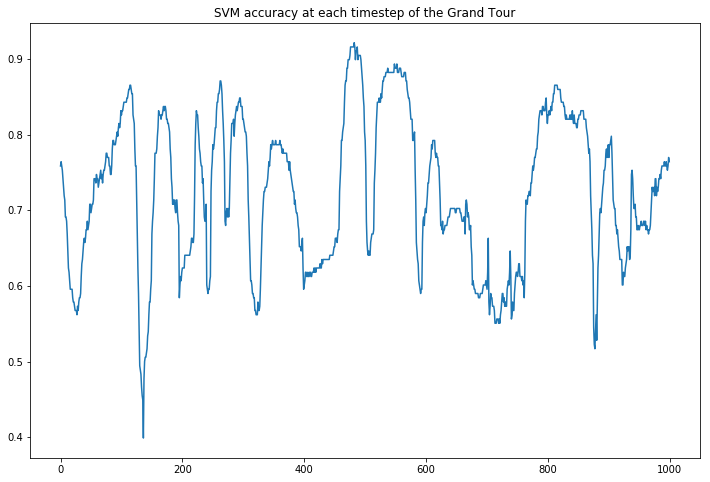

Max SVM accuracy of: 0.9213483146067416
At timestep: 482


In [9]:
plt.figure(figsize=(12,8))
plt.title("SVM accuracy at each timestep of the Grand Tour")
plt.plot(list(range(len(accuracy))), accuracy, '-', marker=" ")
plt.show()

max_accuracy = [i for i, j in enumerate(accuracy) if j == max(accuracy)]

print("Max SVM accuracy of: " + str(max(accuracy)))
print("At timestep: " + str(max_accuracy[0]))

## Neural Network

Need to convert the classification data into a vector with a 1 in the row representing the class

In [10]:
# Make a vector for the classification (used for the Neural Network)
targetData = np.zeros((len(tData[0][0]), 3))
for counter, i in enumerate(classification):
    targetData[counter][int(i-1)] = 1

Generate points uniformaly covering the 2D plane to show the neural network decision boundary

In [11]:
xy_points = []
for i in range(100):
    for j in range(100):
        x = (2 * i - 100) / 100
        y = (2 * j - 100) / 100
        xy_points.append([x, y])
xy_points = np.asarray(xy_points)


Now run the neural network on a specific timestep by using the slider widget

In [12]:
plt.close()
def plot_func(timestep):
    with tf.Session() as sess:
        # format input data
        xData = tData[int(timestep)][0]
        yData = tData[int(timestep)][1]
        trainingData = np.vstack((xData, yData)).T

        # NN model code
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

        model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        
        batch_size = 1
        nnet = model.fit(trainingData, targetData, batch_size=batch_size, epochs=50, verbose=0)
        
        print("batch size: " + str(batch_size))
        print("accuracy measures on each epoch: " + str(nnet.history["acc"]))
        print("timestep: " + str(int(timestep)))
        print("accuracy: " + str((nnet.history["acc"][-1])))
            
        # plot contours    
        x = np.arange(-1.5, 1.5, 0.01)
        y = np.arange(-1.5, 1.5, 0.01)
        xx, yy = np.meshgrid(x, y)
        
        xy = []
        for i in range(len(x)):
            for j in range(len(y)):
                #xy.append([x[i], y[j]])
                xy.append([y[j], x[i]]) # <- this way works 
        xy = np.array(xy)
                
        predictions = model.predict(xy)  
        predictionmax = []
        a = predictions.tolist()
        for i in range(len(a)):
            predictionmax.append(a[i].index(max(a[i])) + 1)

        z = np.reshape(predictionmax, (len(x),len(y)))
        
        plt.figure(figsize=(12, 8))

        plt.contourf(xx, yy, z, colors = ("r", "b", "g"), 
                     levels = 2)

        # plot data
        for i in range(len(xData)):
            formatted_data = [[xData[i], yData[i]]]
            prediction = model.predict(np.array(formatted_data))
            a = prediction.tolist()
            prediction = a[0].index(max(a[0])) + 1
            
            if int(prediction) == classification[i]:
                plt.scatter(xData[i], yData[i], color = 'black', marker = data_marker[i])
            else:
                plt.scatter(xData[i], yData[i], color = data_colour[i], marker = data_marker[i])
        blue_patch = mlines.Line2D([], [], color='blue', marker='o', linestyle="")
        green_patch = mlines.Line2D([], [], color='green', marker='*', linestyle="")
        red_patch = mlines.Line2D([], [], color='red', marker='x', linestyle="")

        xmax, xmin = (max(xData) + 0.1, min(xData) - 0.1)
        ymax, ymin = (max(yData) + 0.1, min(yData) - 0.1)

        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        plt.legend(handles=[blue_patch, red_patch, green_patch])


        plt.show()
        
        
interact_manual(plot_func, timestep = widgets.FloatSlider(value = 1,
                                                   min = 0,
                                                   max = nSteps - 1,
                                                   step = 1))

interactive(children=(FloatSlider(value=1.0, description='timestep', max=999.0, step=1.0), Button(description=…

<function __main__.plot_func(timestep)>

Run the neural network across all timesteps to compare accuracy. 

Note: This may take a long time to run to get an accurate measure of accuracy at each of the timesteps. To speed up this process you can run less epochs but this will have a detremental effect to the accuracy measure

In [13]:
accuracy = []

start = time.clock()

init_op = tf.global_variables_initializer()

iterations = 1000
for i in range(iterations):

    if i % 10 == 0 and i != 0:
        current_time = time.clock() - start
        time_left = (float(current_time) / i) * (iterations - i)
        print("Time elapsed: " + str(current_time))
        print("Timestep: " + str(i) + " out of " + str(iterations))
        print("Approximately " + str(int(time_left / 60)) + " minutes left")
        
    tf.reset_default_graph()

    xData = tData[i][0]
    yData = tData[i][1]
    trainingData = np.vstack((xData, yData)).T
    # NN model code
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    nnet = model.fit(trainingData, targetData, epochs=35, batch_size=1, verbose=0)
    accuracy.append(nnet.history["acc"][-1])
    
x = list(range(0, len(accuracy)))

KeyboardInterrupt: 

Now to plot the accuracy measure against each timestep of the grand tour:

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(x, accuracy, "-", marker="None")
plt.show() 

max_accuracy = max(accuracy)
acc = max_accuracy
max_accuracy = [i for i, j in enumerate(accuracy) if j == max_accuracy]
max_accuracy = max_accuracy[0]
print("max accuracy of: " + str(acc) + ", at timestep: " + str(max_accuracy))

## Decision Tree

Using a decision tree you can make predictions based on decision branches. We will limit the maximum depth of the branches to stop any overfitting.

Using the interactive slider, you can select a timestep and the program will return the decision tree at that timestep along with the decision regions.

In [15]:
classification = np.array(classification)
def plot_func(timestep):

    # format input data
    xData = tData[int(timestep)][0]
    yData = tData[int(timestep)][1]
    trainingData = np.vstack((xData, yData)).T

    """    X_train, X_test, y_train, y_test = train_test_split(nData,
                                                        classification,
                                                        test_size=0.20)
    """
    clf = DecisionTreeClassifier(max_depth=3)
    clf.fit(trainingData, classification)

    predictions = clf.predict(xy_points) 
    
    y_pred = clf.predict(trainingData)

    score = sklearn.metrics.accuracy_score(classification, y_pred)
    print("accuracy score: " + str(score))
    score = sklearn.metrics.cohen_kappa_score(classification, y_pred)
    print("cohen kappa score: " + str(score))

    xy_colour = []
    for i in range(len(predictions)):
        if predictions[i] == 1:
            xy_colour.append("r")
        elif predictions[i] == 2:
            xy_colour.append("b")
        elif predictions[i] == 3:
            xy_colour.append("g")
    
    x = np.arange(-1.5, 1.5, 0.01)
    y = np.arange(-1.5, 1.5, 0.01)
    xx, yy = np.meshgrid(x, y)
    z = np.zeros((len(y),len(x)))

    for i in range(len(x)):
        for j in range(len(y)):
            z[j][i] = int(clf.predict([[x[i],y[j]]]))

    plt.figure(figsize=(12,8))

    plt.contourf(xx, yy, z, colors = ("r", "b", "W", "g"), 
                 levels = 3)
    
    for i in range(len(xData)):
        if int(clf.predict([[xData[i], yData[i]]])) == classification[i]:
            plt.scatter(xData[i], yData[i], color = 'black', marker = data_marker[i])
        else:
            plt.scatter(xData[i], yData[i], color = data_colour[i], marker = data_marker[i])
    blue_patch = mlines.Line2D([], [], color='blue', marker='o', linestyle="")
    green_patch = mlines.Line2D([], [], color='green', marker='*', linestyle="")
    red_patch = mlines.Line2D([], [], color='red', marker='x', linestyle="")
    
    xmax, xmin = (max(xData) + 0.1, min(xData) - 0.1)
    ymax, ymin = (max(yData) + 0.1, min(yData) - 0.1)

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.legend(handles=[blue_patch, red_patch, green_patch])
    plt.show()
        
interact_manual(plot_func, timestep = widgets.FloatSlider(value = 1,
                                                   min = 0,
                                                   max = 1000 - 1,
                                                   step = 1))


interactive(children=(FloatSlider(value=1.0, description='timestep', max=999.0, step=1.0), Button(description=…

<function __main__.plot_func(timestep)>

In [ ]:
type(xy_points)